<a href="https://colab.research.google.com/github/gabrielflorianoo/ProjetoPratico-PI/blob/main/Intel_Image_Classification_Projeto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando as bibliotecas necessárias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image

## Baixando o dataset do kaggle

In [ ]:
# Descomente as linhas abaixo caso não tenha o dataset baixado

! curl -L -o intel-image-classification.zip https://www.kaggle.com/api/v1/datasets/download/puneet6060/intel-image-classification
! unzip intel-image-classification.zip
! rm intel-image-classification.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain

### Esse dataset é separado em 3 seções:

1. Treino localizado na pasta seg_train
2. Teste (ou validação) localizado na pasta seg_test
3. Predição localizado na pasta seg_pred

In [ ]:
# Definindo as rotas das imagens
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'
pred_path = '/content/seg_pred'

### Verificar se tem alguma imagem corrompida

In [ ]:
bad_images = []


for folder in os.listdir(train_path):
    for file in os.listdir(os.path.join(train_path, folder)):
        try:
            img = Image.open(os.path.join(train_path, folder, file))
            img.verify()
        except (IOError, SyntaxError) as e:
            bad_images.append(os.path.join(train_path, folder, file))
            print(f"Imagem corrompida: {os.path.join(train_path, folder, file)}")

for folder in os.listdir(test_path):
    for file in os.listdir(os.path.join(test_path, folder)):
        try:
            img = Image.open(os.path.join(test_path, folder, file))
            img.verify()
        except (IOError, SyntaxError) as e:
            bad_images.append(os.path.join(test_path, folder, file))
            print(f"Imagem corrompida: {os.path.join(test_path, folder, file)}")


pred_path_imgs = pred_path + '/seg_pred'

for file in os.listdir(pred_path_imgs):
    try:
        img = Image.open(os.path.join(pred_path_imgs, file))
        img.verify()
    except (IOError, SyntaxError) as e:
        bad_images.append(os.path.join(pred_path_imgs, file))
        print(f"Imagem corrompida: {os.path.join(pred_path_imgs, file)}")

if len(bad_images) > 0:
    for img in bad_images:
        os.remove(img)
        print(f"Imagem removida: {img}")
else:
    print("Nenhuma imagem corrompida encontrada.")

Nenhuma imagem corrompida encontrada.


#### Vemos que não existem imagens corrompidas nesse dataset, então podemos continuar...

### Definindo configurações

In [ ]:
IMG_SHAPE = (150, 150)
BATCH_SIZE = 32

## Carregando as imagens em um dataset usando image_dataset_from_directory

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(train_path, image_size=IMG_SHAPE, batch_size=BATCH_SIZE)
val_ds = image_dataset_from_directory(test_path, image_size=IMG_SHAPE, batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

In [ ]:
CLASS_NAMES, NUM_CLASSES

(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], 6)

### Nesse dataset temos 6 classes: Edifícios, floresta, geleira, montanha, mar & rua

### Vamos visualizar um pouco dessas imagens:

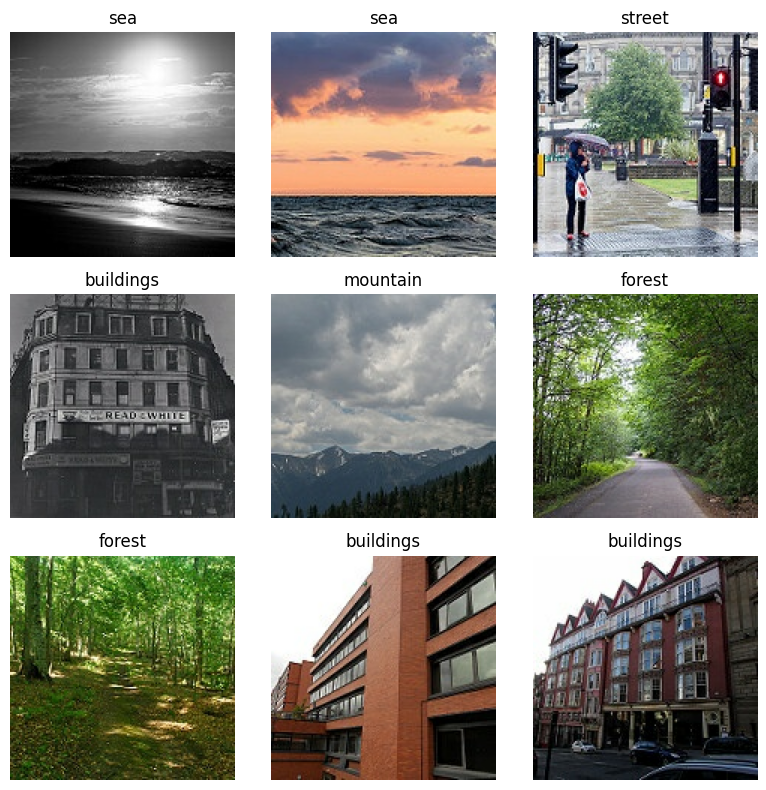

In [ ]:
plt.figure(figsize=(8, 8)) # Difinindo o tamanho do Plot

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

### Como podemos ver, as imagens são coloridas e sem nenhum pré processamento

### Vamos definir o modelo a ser usado, nesse caso vamos usar o ResNet50 como backbone (transfer training) por ser leve, mas ao mesmo tempo bem robusto.

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3), pooling='avg')
base_model.trainable = False # Usado para não causar conflitos com o treino do modelo no futuro

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Criando o modelo proprio para o dataset em questão

As layers antes de base_model são para fazer o pré processamento das imagens quando são inseridas na rede neural, elas servem para que o modelo generalize melhor

base_model é o modelo de backbone, usamos para que seja o centro da rede neural

As layers após o base_model são para fazer o output

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    base_model,
    layers.Flatten(), # Transformar a matriz em um vetor para poder ser lido pela rede neural
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

### Agora vamos compilar e fazer o treinamento do modelo

Usaremos a metrica de precisão, quanto maior melhor, mas devemos ficar atentos, se for muito alta, podemos estar sofrendo de overfitting (quando o modelo se adequa demais aos dados de treinamento e não faz a generalização das features das imagens)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 52s 90ms/step - accuracy: 0.7510 - loss: 0.6807 - val_accuracy: 0.8597 - val_loss: 0.3792
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 94ms/step - accuracy: 0.8496 - loss: 0.4194 - val_accuracy: 0.8737 - val_loss: 0.3398
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.8602 - loss: 0.3775 - val_accuracy: 0.8673 - val_loss: 0.3402
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.8649 - loss: 0.3624 - val_accuracy: 0.8727 - val_loss: 0.3231
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.8747 - loss: 0.3411 - val_accuracy: 0.8787 - val_loss: 0.3299
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.8774 - loss: 0.3394 - val_accuracy: 0.8740 - val_loss: 0.3368
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 78s 86ms/step - accuracy: 0.8862 - loss: 0.3153 - val_accuracy: 0.8803 - val_loss: 0.3192
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.8804 - loss: 0.3290 - 

## Vamos avaliar o modelo agora

### Primeiramente precisamos importar o dataset para fazer a avaliação usando novamente image_dataset_from_directory

In [ ]:
test_ds = image_dataset_from_directory(pred_path, image_size=IMG_SHAPE, batch_size=BATCH_SIZE)

Found 7301 files belonging to 1 classes.


#### model.evaluate se torna inútil pois os dados de predição não estão rotulados, mas podemos usar outras métricas, como a visual, mean_squared_error, confusion_matrix & r2_score

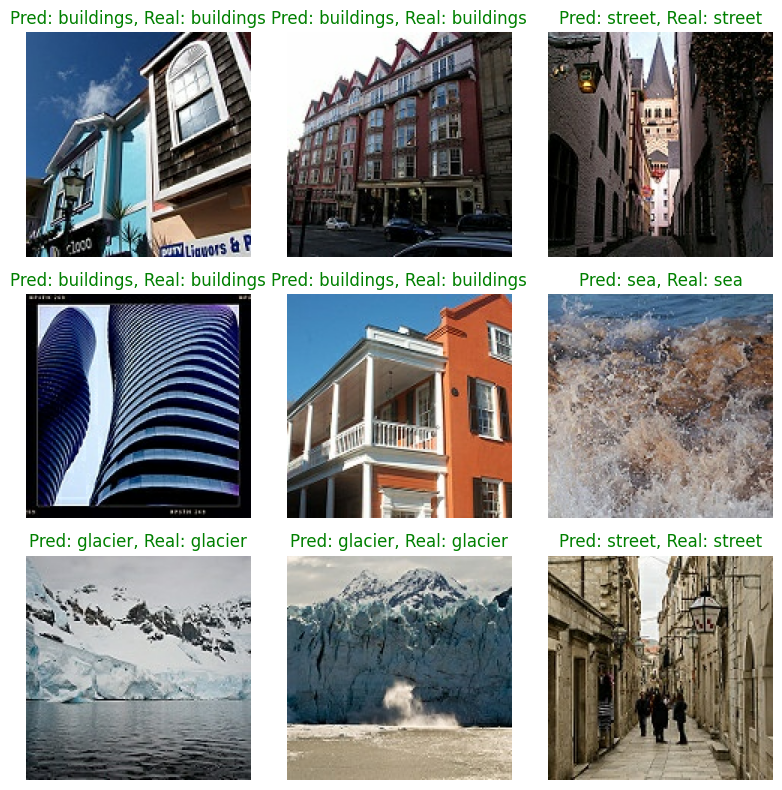

In [ ]:
plt.figure(figsize=(8, 8)) # Difinindo o tamanho do Plot

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred = model.predict(np.expand_dims(images[i], axis=0), verbose=0)

        color = "green" if np.argmax(pred) == labels[i] else "red"
        plt.title(f"Pred: {CLASS_NAMES[np.argmax(pred)]}, Real: {CLASS_NAMES[labels[i]]}", color=color)
        plt.axis("off")

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step
Confusion Matrix:

Mean Squared Error (based on probabilities): 0.2564555417858769


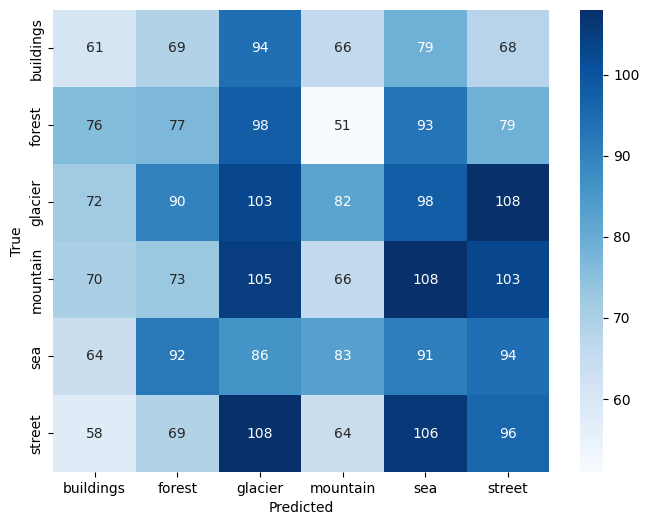

In [ ]:
from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score
import numpy as np
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

predictions = model.predict(val_ds)

predicted_labels = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")

# Plot conf_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')

from tensorflow.keras.utils import to_categorical
true_labels_one_hot = to_categorical(true_labels, num_classes=NUM_CLASSES)
mse = mean_squared_error(true_labels_one_hot.flatten(), predictions.flatten())
print(f"\nMean Squared Error (based on probabilities): {mse}")

### Vemos que o modelo tem uma maior precisão pelo glacier (geleiras), isso pode pelo motivo do dataset estar muito desbalanceado, para melhorar a precisão nas demais classes, precisariamos melhorar esse dataset, deixando-o mais balanceado

In [ ]:
# Por fim vamos plotar o restante
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=CLASS_NAMES))


Classification Report:
              precision    recall  f1-score   support

   buildings       0.15      0.14      0.15       437
      forest       0.16      0.16      0.16       474
     glacier       0.17      0.19      0.18       553
    mountain       0.16      0.13      0.14       525
         sea       0.16      0.18      0.17       510
      street       0.18      0.19      0.18       501

    accuracy                           0.16      3000
   macro avg       0.16      0.16      0.16      3000
weighted avg       0.16      0.16      0.16      3000

